In [65]:
from sklearn.metrics import f1_score, jaccard_similarity_score, roc_auc_score, classification_report, roc_curve, confusion_matrix
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set_style('white')
sns.set_context('paper')
%matplotlib inline

In [66]:
actual_pixel_labels, predicted_pixel_labels = np.load("../results/y.npy"), np.load("../results/output.npy") 

##Save random images

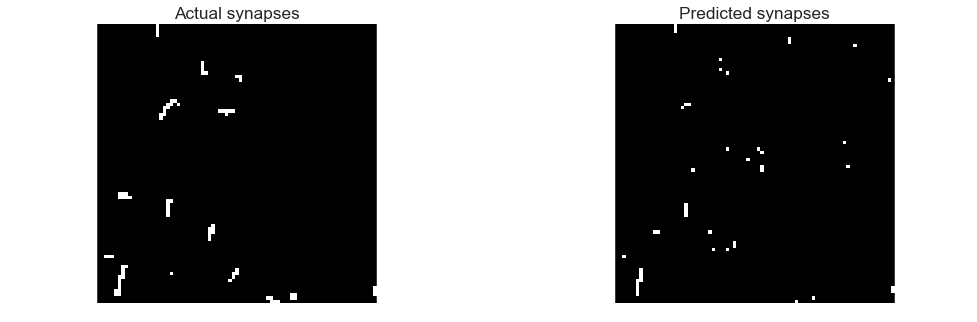

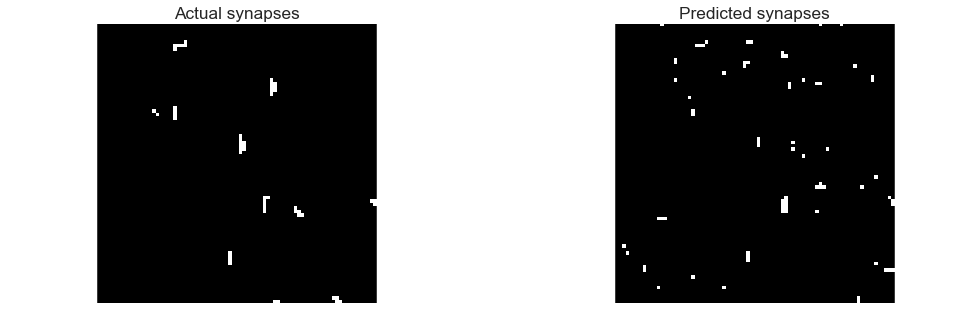

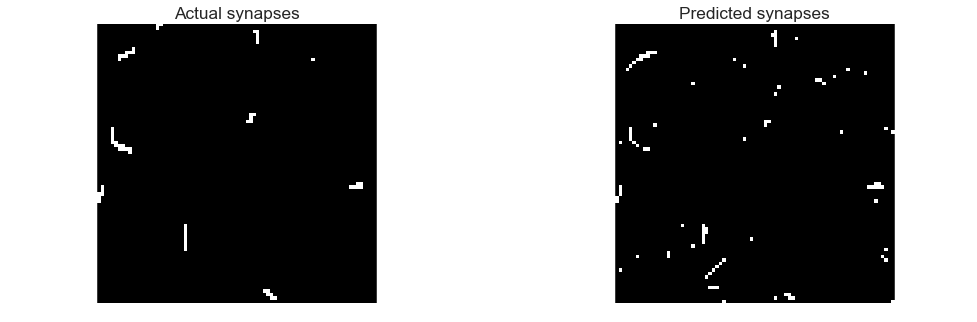

In [67]:
num_images = 3
indices = np.random.choice(actual_pixel_labels.shape[0], num_images, replace=False) 
# create a samples folder within results if it does not yet exist
if not os.path.exists("../results/samples"):
    os.makedirs("../results/samples")

for idx in indices:
    # Two subplots, unpack the axes array immediately
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    
    f.set_size_inches(17, 5)

    ax1.imshow(np.around(actual_pixel_labels[idx]), cmap='bone',  interpolation='nearest')
    ax2.imshow(np.around(predicted_pixel_labels[idx]), cmap='bone',  interpolation='nearest')

    ax1.set_title("Actual synapses", fontsize="xx-large")
    ax2.set_title("Predicted synapses", fontsize="xx-large")
    
    ax1.set_axis_off()
    ax2.set_axis_off()
    
    f.savefig("../results/samples/comparison_" + str(idx) + ".png")
    misc.imsave('../results/samples/predicted ' + str(idx) + '.png', np.around(predicted_pixel_labels[idx]))
    misc.imsave('../results/samples/actual ' + str(idx) + '.png', np.around(actual_pixel_labels[idx]))

##Output Stats


In [68]:
y_actual = np.around(actual_pixel_labels.flatten())
y_predicted = np.around(predicted_pixel_labels.flatten())

f1 = f1_score(y_actual, y_predicted, labels=[0, 1], average='binary')
jaccard = jaccard_similarity_score(y_actual, y_predicted)
auc = roc_auc_score(y_actual, y_predicted)
report = classification_report(y_actual, y_predicted, target_names=["non-synapses", "synapses"])
confusion_mat = confusion_matrix(y_actual, y_predicted)

output_str =  "F1 score is " + str(f1)
output_str += "\nJaccard similarity score is " + str(jaccard)
output_str += "\nROC AUC score is " + str(auc)
output_str += "\nFull Classification Report:\n " + str(report)

print output_str
with open("../results/output_stats.txt", "w") as text_file:
    text_file.write(output_str)

F1 score is 0.418128654971
Jaccard similarity score is 0.987867703094
ROC AUC score is 0.701343178467
Full Classification Report:
               precision    recall  f1-score   support

non-synapses       0.99      0.99      0.99     32455
    synapses       0.43      0.41      0.42       350

 avg / total       0.99      0.99      0.99     32805



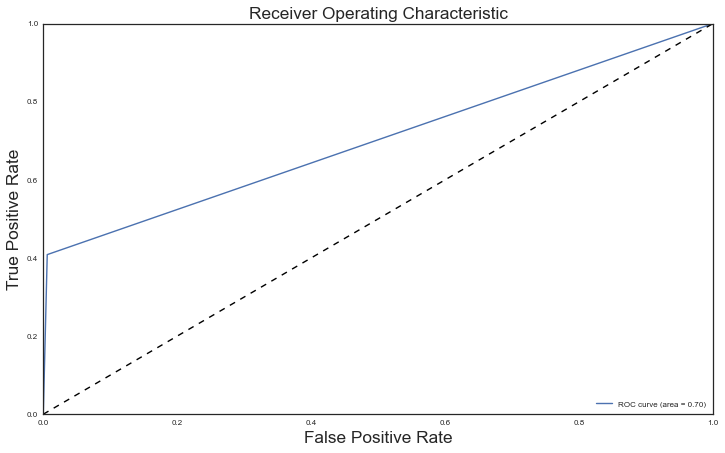

In [69]:
fpr, tpr, thresholds = roc_curve(y_actual, y_predicted)
plt.figure(figsize=(12, 7))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate', fontsize="xx-large")
plt.ylabel('True Positive Rate', fontsize="xx-large")
plt.title('Receiver Operating Characteristic', fontsize="xx-large")
plt.legend(loc="lower right")
plt.savefig("../results/roc_curve.png")
plt.show()